In [38]:
from config import N_HAND_LANDMARKS, N_POSE_LANDMARKS, EPSILON_BODY, EPSILON_HAND_FINGER, EPSILON_EYE
import random
import numpy as np

K_BODY = random.uniform(0.85, 1.25)
K_FINGER = 0.9*K_BODY

def distance(M1, M2):
    """Calculate euclidean distance between two points."""
    x1, y1, z1 = tuple(M1)
    x2, y2, z2 = tuple(M2)
    d = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2)
    return d

def create_noise_point(point, eps):
    """Create new point displaced any epsilon from the origin point."""
    
    x, y, z = tuple(point)
    ex = random.uniform(-eps, eps)
    ey = random.uniform(-eps, eps)
    # ez = random.uniform(-0.5, 0.5)
    return [x + ex, y + ey, 0]

def create_point_by_k(A, B, M, k):
    """Create a new point M' such that vector MM' is k times vector AB."""
    xA, yA, zA = tuple(A)
    xB, yB, zB = tuple(B)
    xM, yM, zM = tuple(M)
    x = abs(xB) - abs(xA)
    y = abs(yB) - abs(yA)
    # z = zB - zA
    return [xM + k * x, yM + k *y, 0]

def calculate_k(A1, B1, M1, N1):
    """Calculate distortion coefficient k between origin frame and augmented frame."""
    d1 = distance(A1, B1)
    if d1==0:
        d1=1
    h1 = distance(M1, N1)
    k1 = h1 / d1
    return k1

def calculate_start_point(A1, B1, A2, B2, M1, N1):
    k0 = K_BODY
    M2 = create_point_by_k(A1, A2, M1, k0)
    k1 = calculate_k(A1, B1, M1, N1)
    N2 = create_point_by_k(A2, B2, M2, k1)
    return M2, N2

def create_next_point(A1, B1, A2, B2, M1, N1, M2):
    k1 = calculate_k(A1, B1, M1, N1)
    N2 = create_point_by_k(A2, B2, M2, k1)
    return N2

def create_frame_0(list_frames_keypoints):
    """
    Choose right_shoulder as the main point to generate other points.
    k: the global body transformation rate.
    """
    
    right_hand_result = []
    left_hand_result = []
    pose_result = [[0, 0, 0]] * N_POSE_LANDMARKS
    
    start_frame = list_frames_keypoints[0]
    # start_frame[0]: left_hand_landmarks
    # start_frame[1]: right_hand_landmarks
    # start_frame[2]: pose_landmarks
    
    point_12 = create_noise_point(start_frame[2][12], 0.01)
    k =  random.uniform(0.8, 1.2)
    point_14 = create_point_by_k(start_frame[2][12], start_frame[2][14], point_12, k)
    point_14 = create_noise_point(point_14, EPSILON_BODY)
    point_16 = create_point_by_k(start_frame[2][14], start_frame[1][0], point_14, k)
    point_16 = create_noise_point(point_16, EPSILON_BODY)
    point_1_r = create_point_by_k(start_frame[1][0], start_frame[1][1], point_16, k)
    point_1_r = create_noise_point(point_1_r, EPSILON_HAND_FINGER)
    right_hand_result.append(point_16)
    right_hand_result.append(point_1_r)
    for i in range(2, 21):
        if i % 4 != 1:
            point_r = create_point_by_k(start_frame[1][i-1], start_frame[1][i], right_hand_result[i-1], k)
            point_r = create_noise_point(point_r, EPSILON_HAND_FINGER)
            right_hand_result.append(point_r)
        else:
            if i == 5:
                point_5_r = create_point_by_k(start_frame[1][0], start_frame[1][5], right_hand_result[0], k)
                point_5_r = create_noise_point(point_5_r, EPSILON_HAND_FINGER)
                right_hand_result.append(point_5_r)
            else:
                point_r = create_point_by_k(start_frame[1][i-4], start_frame[1][i], right_hand_result[i-4], k)
                point_r = create_noise_point(point_r, EPSILON_HAND_FINGER)
                right_hand_result.append(point_r)
    
    # 11 - left_shoulder, 13 - left_elbow 
    point_11 = create_point_by_k(start_frame[2][12], start_frame[2][11], point_12, k)
    point_11 = create_noise_point(point_11, EPSILON_BODY)
    point_13 = create_point_by_k(start_frame[2][11], start_frame[2][13], point_11, k)
    point_13 = create_noise_point(point_13, EPSILON_BODY)
    # 15 - left_wrist
    point_15 = create_point_by_k(start_frame[2][13], start_frame[0][0], point_13, k)
    point_15 = create_noise_point(point_15, EPSILON_BODY)
    point_1_l = create_point_by_k(start_frame[0][0], start_frame[0][1], point_15, k)
    point_1_l = create_noise_point(point_1_l, EPSILON_HAND_FINGER)
    left_hand_result.append(point_15)
    left_hand_result.append(point_1_l)
    for i in range(2, 21):
        if i % 4 != 1:
            point_l = create_point_by_k(start_frame[0][i - 1], start_frame[0][i], left_hand_result[i - 1], k)
            point_l = create_noise_point(point_l, EPSILON_HAND_FINGER)
            left_hand_result.append(point_l)
        else:
            if i == 5:
                point_5_l = create_point_by_k(start_frame[0][0], start_frame[0][5], left_hand_result[0], k)
                point_5_l = create_noise_point(point_5_l, EPSILON_HAND_FINGER)
                left_hand_result.append(point_5_l)
            else:
                point_l = create_point_by_k(start_frame[0][i - 4], start_frame[0][i], left_hand_result[i - 4], k)
                point_l = create_noise_point(point_l, EPSILON_HAND_FINGER)
                left_hand_result.append(point_l)
    
    point_24 = create_point_by_k(start_frame[2][12], start_frame[2][16], point_12, k)
    point_23 = create_point_by_k(start_frame[2][16], start_frame[2][15], point_24, k)
    
    point_10 = create_point_by_k(start_frame[2][12], start_frame[2][10], point_12, k)
    point_9 = create_point_by_k(start_frame[2][10], start_frame[2][9], point_10, k)
    
    point_0 = create_point_by_k(start_frame[2][10], start_frame[2][0], point_10, k)
    
    point_1 = create_point_by_k(start_frame[2][0], start_frame[2][1], point_0, k)
    point_2 = create_point_by_k(start_frame[2][1], start_frame[2][2], point_1, k)
    point_3 = create_point_by_k(start_frame[2][2], start_frame[2][3], point_2, k)
    point_7 = create_point_by_k(start_frame[2][3], start_frame[2][7], point_3, k)
    
    point_4 = create_point_by_k(start_frame[2][0], start_frame[2][4], point_0, k)
    point_5 = create_point_by_k(start_frame[2][4], start_frame[2][5], point_4, k)
    point_6 = create_point_by_k(start_frame[2][5], start_frame[2][6], point_5, k)
    point_8 = create_point_by_k(start_frame[2][6], start_frame[2][8], point_6, k)
    
    list_pose_points = [point_0, point_1, point_2, point_3, point_4, point_5, point_6, point_7, point_8, point_9, point_10,
                        point_11, point_12, point_13, point_14, point_23, point_24]

    for i in range(0, 17):
        if i < 11:
            pose_result[i] = create_noise_point(list_pose_points[i], EPSILON_EYE)
        else:
            pose_result[i] = create_noise_point(list_pose_points[i], EPSILON_BODY)
            
    frame_0 = [left_hand_result, right_hand_result, pose_result]
    return frame_0
    
def create_frame_t(t, list_frames_keypoints, frame_start):
    pose_result = [[0, 0, 0]] * N_POSE_LANDMARKS
    right_hand_result = []
    left_hand_result = []
    frame_current = list_frames_keypoints[t]  # A2B2
    frame_0 = list_frames_keypoints[0]  # A1B1
    
    point_12, point_14 = calculate_start_point(frame_0[2][12], frame_0[2][14], frame_current[2][12],
                                               frame_current[2][14], frame_start[2][12], frame_start[2][14])
    point_16 = create_next_point(frame_0[2][14], frame_0[1][0], frame_current[2][14], frame_current[1][0],
                                 frame_start[2][14], frame_start[1][0], point_14)
    point_11 = create_next_point(frame_0[2][12], frame_0[2][11], frame_current[2][12], frame_current[2][11],
                                 frame_start[2][12], frame_start[2][11], point_12)
    point_13 = create_next_point(frame_0[2][11], frame_0[2][13], frame_current[2][11], frame_current[2][13],
                                 frame_start[2][11], frame_start[2][13], point_11)
    point_15 = create_next_point(frame_0[2][13], frame_0[0][0], frame_current[2][13], frame_current[0][0],
                                 frame_start[2][13], frame_start[0][0], point_13)
    point_24 = create_next_point(frame_0[2][12], frame_0[2][16], frame_current[2][12], frame_current[2][16],
                                 frame_start[2][12], frame_start[2][16], point_12)
    point_23 = create_next_point(frame_0[2][16], frame_0[2][15], frame_current[2][16], frame_current[2][15],
                                 frame_start[2][16], frame_start[2][15], point_24)
    
    
    point_10 = create_next_point(frame_0[2][12], frame_0[2][10], frame_current[2][12], frame_current[2][10],
                                 frame_start[2][12], frame_start[2][10], point_12)
    point_9 = create_next_point(frame_0[2][10], frame_0[2][9], frame_current[2][10], frame_current[2][9],
                                frame_start[2][10], frame_start[2][9], point_10)
    point_0 = create_next_point(frame_0[2][10], frame_0[2][0], frame_current[2][10], frame_current[2][0],
                                frame_start[2][10], frame_start[2][0], point_10)
    point_1 = create_next_point(frame_0[2][0], frame_0[2][1], frame_current[2][0], frame_current[2][1],
                                frame_start[2][0], frame_start[2][1], point_0)
    point_2 = create_next_point(frame_0[2][1], frame_0[2][2], frame_current[2][1], frame_current[2][2],
                                frame_start[2][1], frame_start[2][2], point_1)
    point_3 = create_next_point(frame_0[2][2], frame_0[2][3], frame_current[2][2], frame_current[2][3],
                                frame_start[2][2], frame_start[2][3], point_2)
    point_4 = create_next_point(frame_0[2][0], frame_0[2][4], frame_current[2][0], frame_current[2][4],
                                frame_start[2][0], frame_start[2][4], point_0)
    point_5 = create_next_point(frame_0[2][4], frame_0[2][5], frame_current[2][4], frame_current[2][5],
                                frame_start[2][4], frame_start[2][5], point_4)
    point_6 = create_next_point(frame_0[2][5], frame_0[2][6], frame_current[2][5], frame_current[2][6],
                                frame_start[2][5], frame_start[2][6], point_5)
    point_7 = create_next_point(frame_0[2][3], frame_0[2][7], frame_current[2][3], frame_current[2][7],
                                frame_start[2][3], frame_start[2][7], point_3)
    point_8 = create_next_point(frame_0[2][6], frame_0[2][8], frame_current[2][6], frame_current[2][8],
                                frame_start[2][6], frame_start[2][8], point_6)
    
    list_pose_points = [point_0, point_1, point_2, point_3, point_4, point_5, point_6, point_7, point_8, point_9, point_10,
                        point_11, point_12, point_13, point_14, point_23, point_24]
    
    for i in range(0, 17):
        if i < 11:
            pose_result[i] = create_noise_point(list_pose_points[i], EPSILON_EYE)
        else:
            pose_result[i] = create_noise_point(list_pose_points[i], EPSILON_BODY)
    
    left_hand_result.append(point_15)
    point_1_l = create_next_point(frame_0[0][0], frame_0[0][1], frame_current[0][0], frame_current[0][1],
                                  frame_start[0][0], frame_start[0][1], point_15)
    left_hand_result.append(point_1_l)
    for i in range(2, 21):
        if i % 4 != 1:
            point_l = create_next_point(frame_0[0][i - 1], frame_0[0][i], frame_current[0][i - 1], frame_current[0][i],
                                        frame_start[0][i - 1], frame_start[0][i],
                                        left_hand_result[i - 1])
            point_l = create_noise_point(point_l, EPSILON_HAND_FINGER)
            left_hand_result.append(point_l)
        else:
            if i == 5:
                point_5_l = create_next_point(frame_0[0][0], frame_0[0][5], frame_current[0][0], frame_current[0][5],
                                              frame_start[0][0], frame_start[0][5], left_hand_result[0])
                point_5_l = create_noise_point(point_5_l, EPSILON_HAND_FINGER)
                left_hand_result.append(point_5_l)
            else:
                point_l = create_next_point(frame_0[0][i - 4], frame_0[0][i], frame_current[0][i - 4],
                                            frame_current[0][i],
                                            frame_start[0][i - 4], frame_start[0][i], left_hand_result[i - 4])
                point_l = create_noise_point(point_l, EPSILON_HAND_FINGER)
                left_hand_result.append(point_l)
                
    right_hand_result.append(point_16)
    point_1_r = create_next_point(frame_0[1][0], frame_0[1][1], frame_current[1][0], frame_current[1][1],
                                  frame_start[1][0], frame_start[1][1], point_16)
    right_hand_result.append(point_1_r)
    for i in range(2, 21):
        if i % 4 != 1:
            point_r = create_next_point(frame_0[1][i - 1], frame_0[1][i], frame_current[1][i - 1], frame_current[1][i],
                                        frame_start[1][i - 1], frame_start[1][i],
                                        right_hand_result[i - 1])
            point_r = create_noise_point(point_r, EPSILON_HAND_FINGER)
            right_hand_result.append(point_r)
        else:
            if i == 5:
                point_5_r = create_next_point(frame_0[1][0], frame_0[1][5], frame_current[1][0], frame_current[1][5],
                                              frame_start[1][0], frame_start[1][5], right_hand_result[0])
                point_5_r = create_noise_point(point_5_r, EPSILON_HAND_FINGER)
                right_hand_result.append(point_5_r)
            else:
                point_r = create_next_point(frame_0[1][i - 4], frame_0[1][i], frame_current[1][i - 4],
                                            frame_current[1][i],
                                            frame_start[1][i - 4], frame_start[1][i], right_hand_result[i - 4])
                point_r = create_noise_point(point_r, EPSILON_HAND_FINGER)
                right_hand_result.append(point_r)
                
    return [left_hand_result, right_hand_result, pose_result]

In [39]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

src_data = np.load("../notebooks/dataset/visualization/0.npy", allow_pickle=True)

try:
    result = []
    frame_0 = create_frame_0(src_data)
    result.append(frame_0)
    
    for i in range(1, 20):
        frame_t = create_frame_t(i, src_data, frame_0)
        result.append(frame_t)
    aug_data = np.asarray(result, dtype="object")
except Exception as e:
    print(f"error when generate augmented data: {e}.")

In [40]:
def add_keypoints_to_image(image, list_landmarks, color=(0, 255, 0)):
    """Plot image with keypoints."""
    
    image_height, image_width, _ = image.shape
    for (x, y, _) in list_landmarks:
        if x != 0 and y != 0:
            px = int(x * image_width)
            py = int(y * image_height)
            cv2.circle(image, (px, py), 4, color, -1)

red, blue, green = (0, 0, 255), (255, 0, 0), (0, 255, 0)

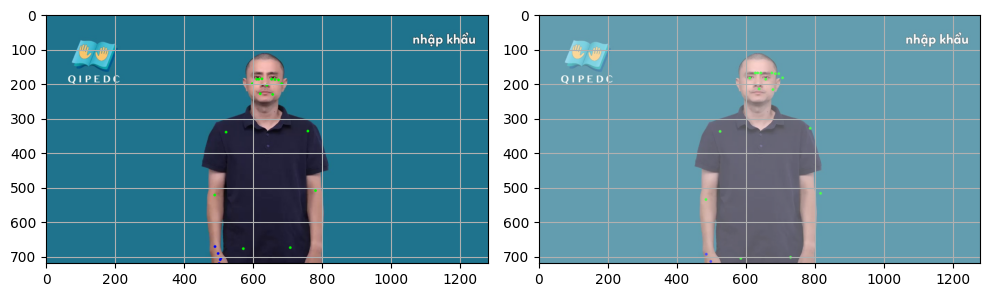

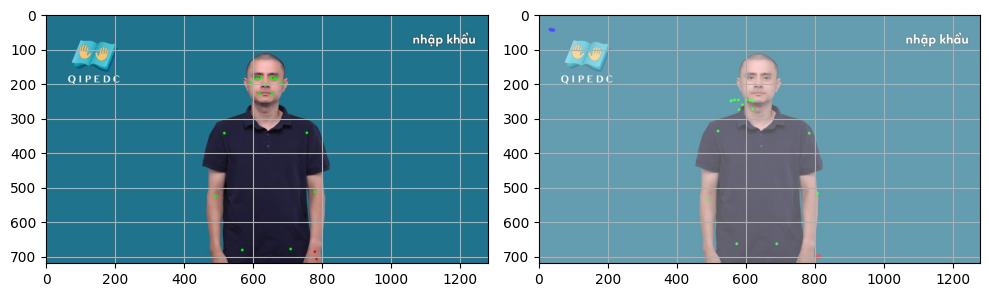

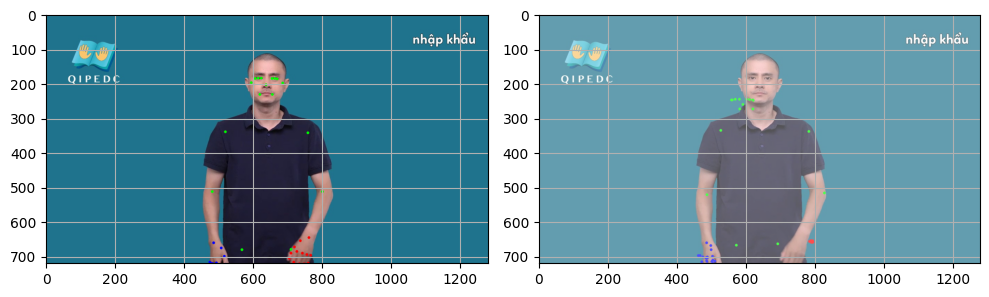

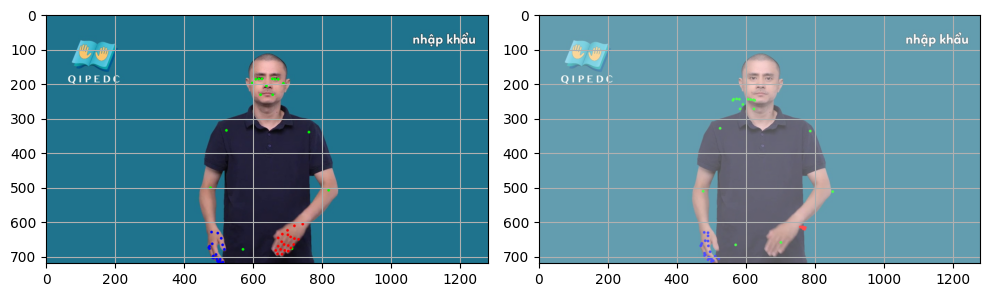

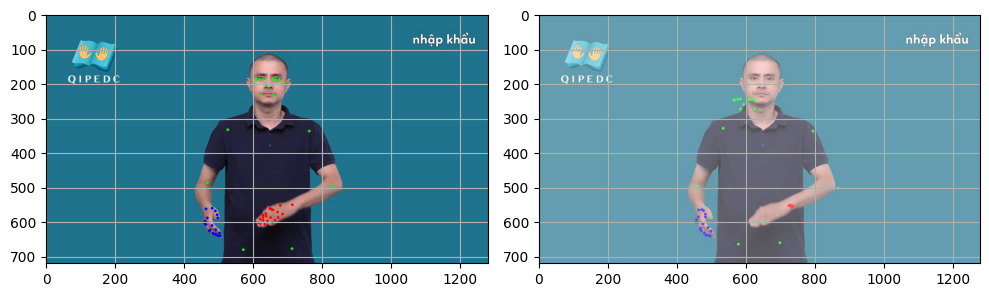

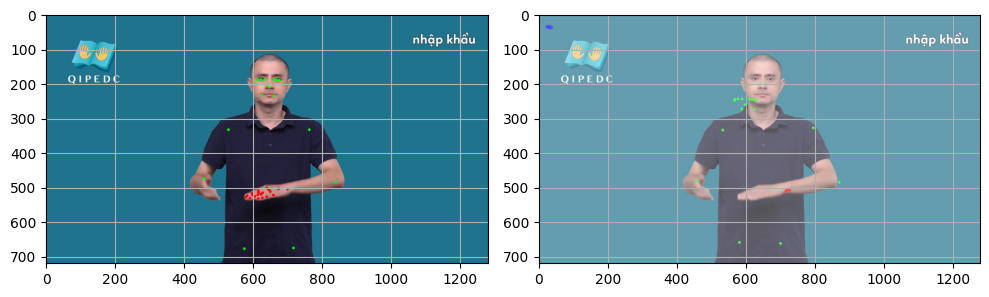

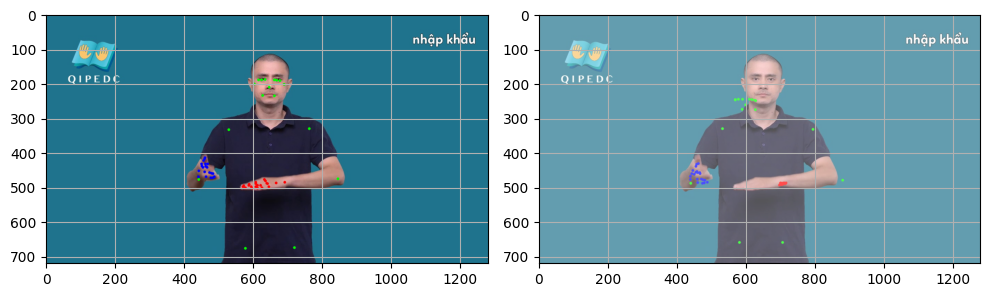

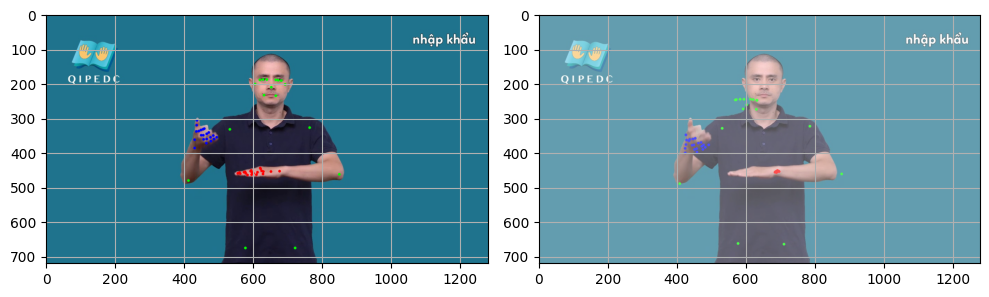

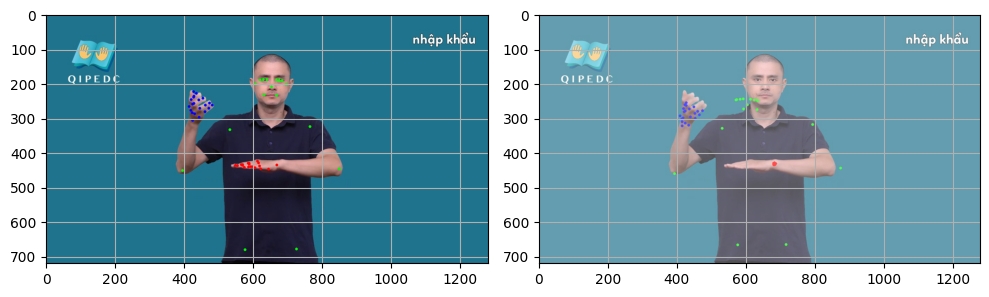

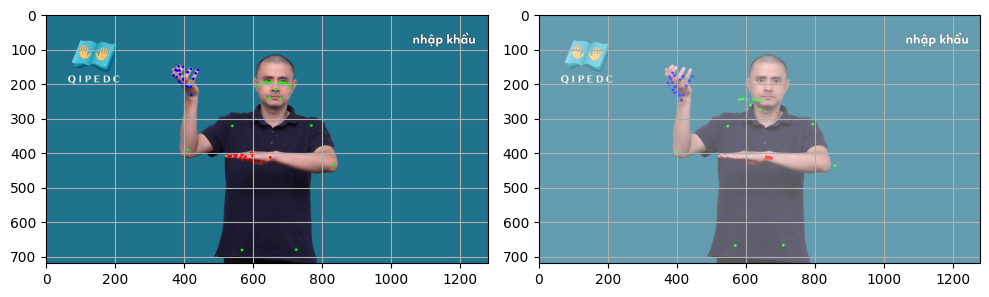

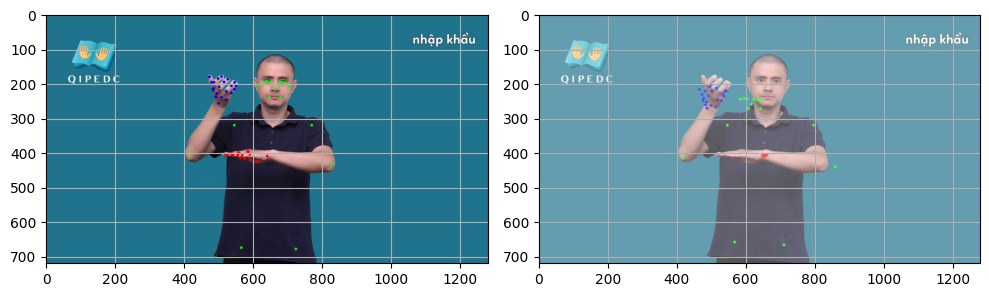

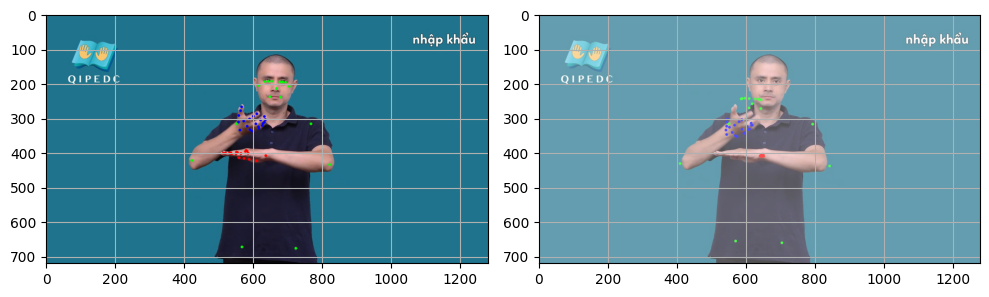

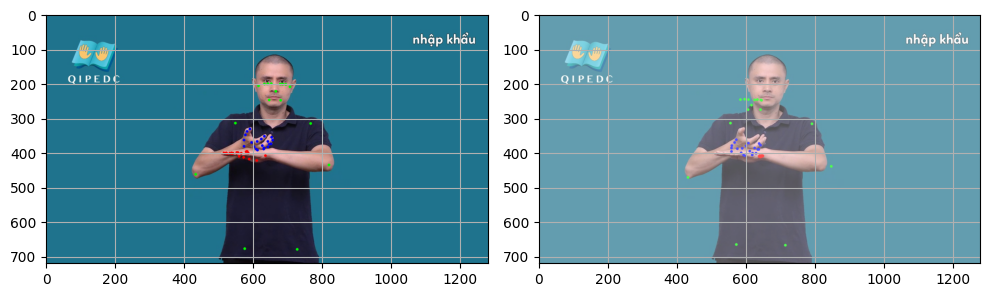

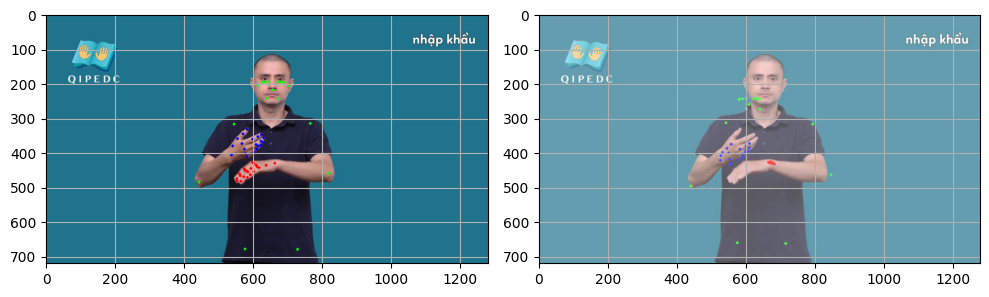

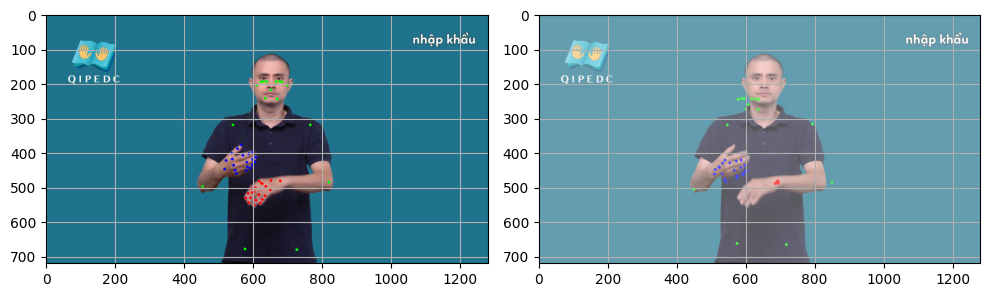

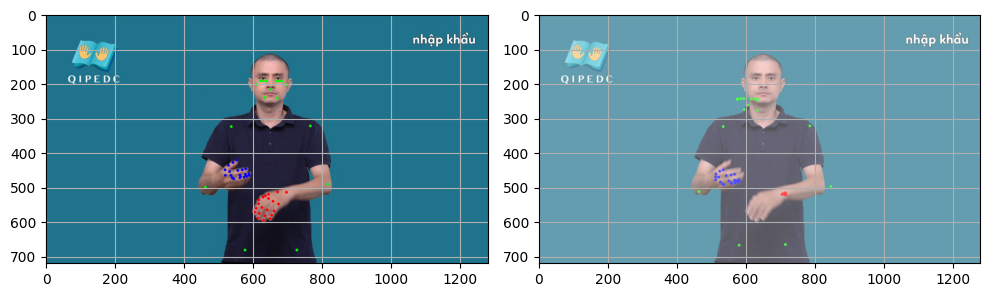

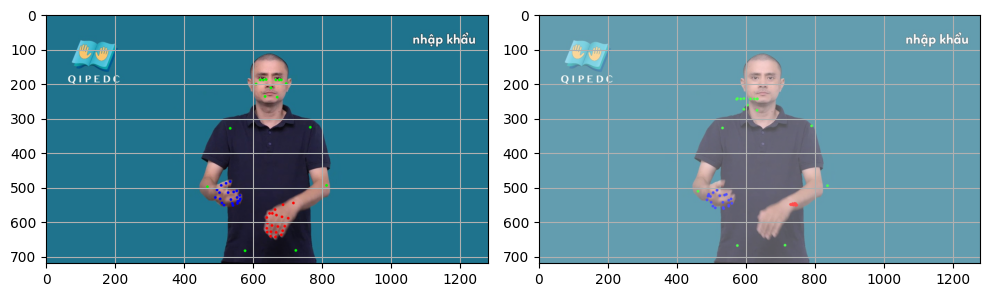

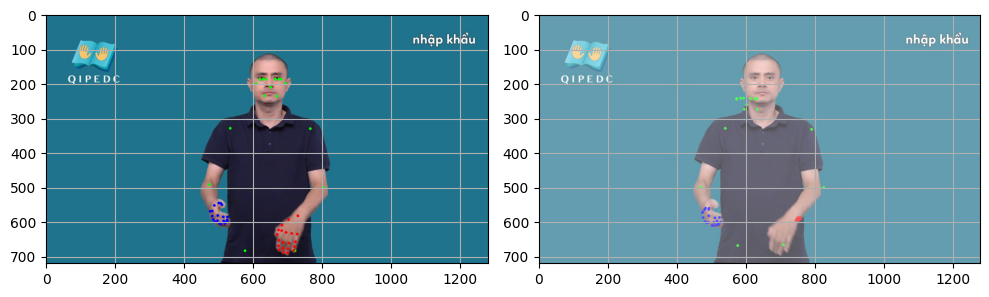

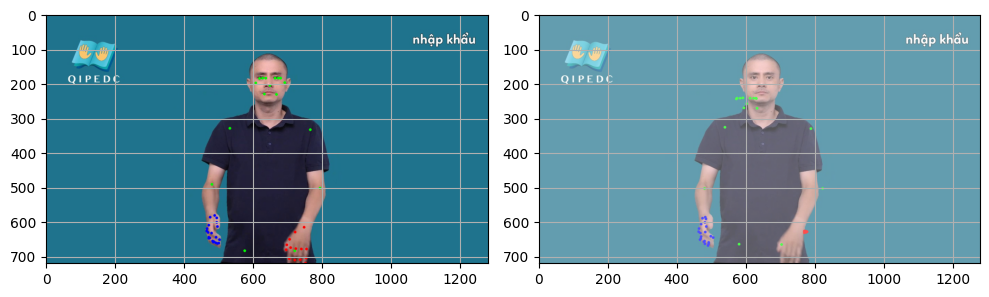

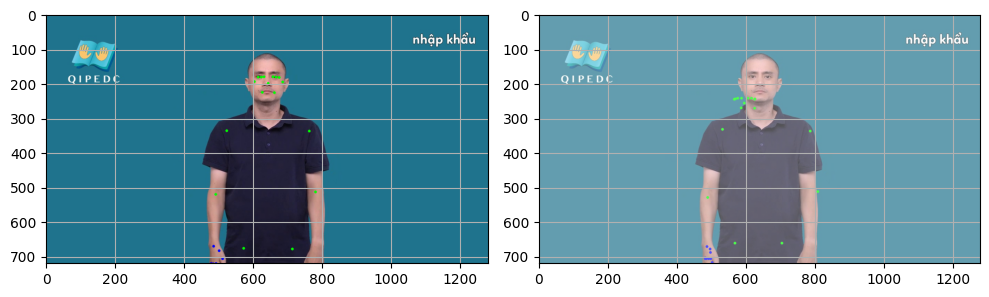

In [41]:
frame_list = [1, 34, 38, 40, 42, 44, 45, 47, 49, 62, 68, 72, 88, 95, 97, 98, 99, 100, 101, 106]

for t, frame in enumerate(src_data):
    src_frame_0 = src_data[0]
    src_frame_t = src_data[t]
    aug_frame_t = aug_data[t]
    
    plt.figure(figsize=(10, 20))
    for i in range(0, 2):
        plt.subplot(1, 2, i+1)
        image_0 = cv2.imread(f"../notebooks/dataset/visualization/images/frame_{1}.jpg")
        image = cv2.imread(f"../notebooks/dataset/visualization/images/frame_{frame_list[t]}.jpg")
        
        if i == 0: # origin keypoints
            data = src_frame_t
            alpha=1
            lh, rh, pose = data
            add_keypoints_to_image(image, pose, color=green)
            add_keypoints_to_image(image, lh, color=red)
            add_keypoints_to_image(image, rh, color=blue)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), alpha=alpha)
        else:
            data = aug_frame_t
            alpha=0.7
            lh, rh, pose = data
            add_keypoints_to_image(image, pose, color=green)
            add_keypoints_to_image(image, lh, color=red)
            add_keypoints_to_image(image, rh, color=blue)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), alpha=alpha)
        # display_image(image, axis=True, grid=True, alpha=alpha)  
        
        plt.axis()
        plt.grid()
            
    plt.tight_layout()
    plt.show()

In [21]:
aug_frame_1 = create_frame_t(1, src_data, frame_0)

In [32]:
def check_point(data, text):
    print(text)
    lh, rh, pose = data
    print("   Left hand:")
    for i, values in enumerate(lh):
        x, y, _ = values
        print(f"    point {i}: x =", x, ", y =", y)

    print("   Right hand:")
    for i, values in enumerate(rh):
        x, y, _ = values
        print(f"    point {i}: x =", x, ", y =", y)

    print("   Pose:")
    for i, values in enumerate(pose):
        x, y, _ = values
        if i == 15:
            print(f"    point 23: x =", x, ", y =", y)
            continue
        if i == 16: 
            print(f"    point 24: x =", x, ", y =", y)
            break
        print(f"    point {i}: x =", x, ", y =", y)

In [33]:
check_point(src_data[0], text="frame_0")

frame_0
   Left hand:
    point 0: x = 0.0 , y = 0.0
    point 1: x = 0.0 , y = 0.0
    point 2: x = 0.0 , y = 0.0
    point 3: x = 0.0 , y = 0.0
    point 4: x = 0.0 , y = 0.0
    point 5: x = 0.0 , y = 0.0
    point 6: x = 0.0 , y = 0.0
    point 7: x = 0.0 , y = 0.0
    point 8: x = 0.0 , y = 0.0
    point 9: x = 0.0 , y = 0.0
    point 10: x = 0.0 , y = 0.0
    point 11: x = 0.0 , y = 0.0
    point 12: x = 0.0 , y = 0.0
    point 13: x = 0.0 , y = 0.0
    point 14: x = 0.0 , y = 0.0
    point 15: x = 0.0 , y = 0.0
    point 16: x = 0.0 , y = 0.0
    point 17: x = 0.0 , y = 0.0
    point 18: x = 0.0 , y = 0.0
    point 19: x = 0.0 , y = 0.0
    point 20: x = 0.0 , y = 0.0
   Right hand:
    point 0: x = 0.39153775572776794 , y = 1.0017980337142944
    point 1: x = 0.3944830596446991 , y = 0.9870507717132568
    point 2: x = 0.3957335352897644 , y = 0.9806971549987793
    point 3: x = 0.38910382986068726 , y = 0.9621056318283081
    point 4: x = 0.3824978768825531 , y = 0.93354284763

In [34]:
check_point(src_data[1], text="frame_current")

frame_current
   Left hand:
    point 0: x = 0.6080380082130432 , y = 0.9550174474716187
    point 1: x = 0.6121885776519775 , y = 0.9845400452613831
    point 2: x = 0.61122727394104 , y = 1.0192575454711914
    point 3: x = 0.6060591340065002 , y = 1.0450012683868408
    point 4: x = 0.601230800151825 , y = 1.0641833543777466
    point 5: x = 0.6170858144760132 , y = 1.0386139154434204
    point 6: x = 0.6114961504936218 , y = 1.0790259838104248
    point 7: x = 0.6065975427627563 , y = 1.102980136871338
    point 8: x = 0.6029163002967834 , y = 1.1189709901809692
    point 9: x = 0.6117956638336182 , y = 1.0408369302749634
    point 10: x = 0.6066046357154846 , y = 1.0818092823028564
    point 11: x = 0.6024551391601562 , y = 1.1040542125701904
    point 12: x = 0.5992571115493774 , y = 1.1209280490875244
    point 13: x = 0.6039513349533081 , y = 1.0398088693618774
    point 14: x = 0.6003248691558838 , y = 1.0798065662384033
    point 15: x = 0.5976149439811707 , y = 1.09989333152

In [35]:
aug_frame_0 = create_frame_0(src_data)
check_point(aug_frame_0, text="frame_start")

frame_start
   Left hand:
    point 0: x = -0.05722723146474912 , y = -0.0650185436510765
    point 1: x = -0.05459079518517193 , y = -0.06248159125565494
    point 2: x = -0.057009580064718124 , y = -0.06076878233053037
    point 3: x = -0.057799220951961564 , y = -0.06187054451241239
    point 4: x = -0.05690003854401618 , y = -0.06035008283260932
    point 5: x = -0.05914604429798398 , y = -0.06255081003490463
    point 6: x = -0.05744218988086159 , y = -0.06001548433874448
    point 7: x = -0.05997640873302697 , y = -0.06230621931273083
    point 8: x = -0.05956432171377657 , y = -0.05942317189439853
    point 9: x = -0.0584899718424243 , y = -0.06051287925002229
    point 10: x = -0.05765327297100577 , y = -0.06298131130317322
    point 11: x = -0.05982240767178096 , y = -0.061367960839261895
    point 12: x = -0.06217397059601164 , y = -0.06426155804825746
    point 13: x = -0.05783123236718604 , y = -0.060800336652746687
    point 14: x = -0.05983746589692289 , y = -0.0614566454

In [42]:
aug_frame_1 = create_frame_t(1, src_data, aug_frame_0)
check_point(aug_frame_1, text="frame_start")

frame_start
   Left hand:
    point 0: x = 0.6168157808258943 , y = 0.9828674642891903
    point 1: x = 0.6168309669896357 , y = 0.9829754819987369
    point 2: x = 0.6162689917066905 , y = 0.9844017149027283
    point 3: x = 0.6188794481073534 , y = 0.9817830126579385
    point 4: x = 0.6211928290593606 , y = 0.980950880126782
    point 5: x = 0.6197871162155246 , y = 0.9831157478840303
    point 6: x = 0.6220063065189674 , y = 0.9817411419940439
    point 7: x = 0.6210680044487888 , y = 0.9790358755987688
    point 8: x = 0.6200987892492894 , y = 0.9761342736953934
    point 9: x = 0.619955164025845 , y = 0.9825523381406348
    point 10: x = 0.6204555279308118 , y = 0.9831209646221641
    point 11: x = 0.6206087318341831 , y = 0.983443424302982
    point 12: x = 0.6197328494174461 , y = 0.9827416152202415
    point 13: x = 0.6199708631048129 , y = 0.9809343120236017
    point 14: x = 0.6202607802742508 , y = 0.9780625606600635
    point 15: x = 0.6203518159751831 , y = 0.977921410657